In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import sem
import bambi
import arviz as az
import pymc3 as pm

import matplotlib.pyplot as plt
%matplotlib inline
from seaborn import despine

from utils.plotting import cm2inch 
from utils.stats import get_var

# Data I/O

In [2]:
subjects = np.arange(49)
setsizes = np.array([9,16,25,36])
colors = ['darkturquoise', 'orange', 'mediumseagreen', 'lightcoral']
mfx_dir = 'results/posterior_traces/mixed_effects_models/'

Mean: 1497.53 (SE: 8.66)
Mean: 1539.47 (SE: 8.38)
Mean: 1567.83 (SE: 8.89)
Mean: 1585.81 (SE: 9.07)


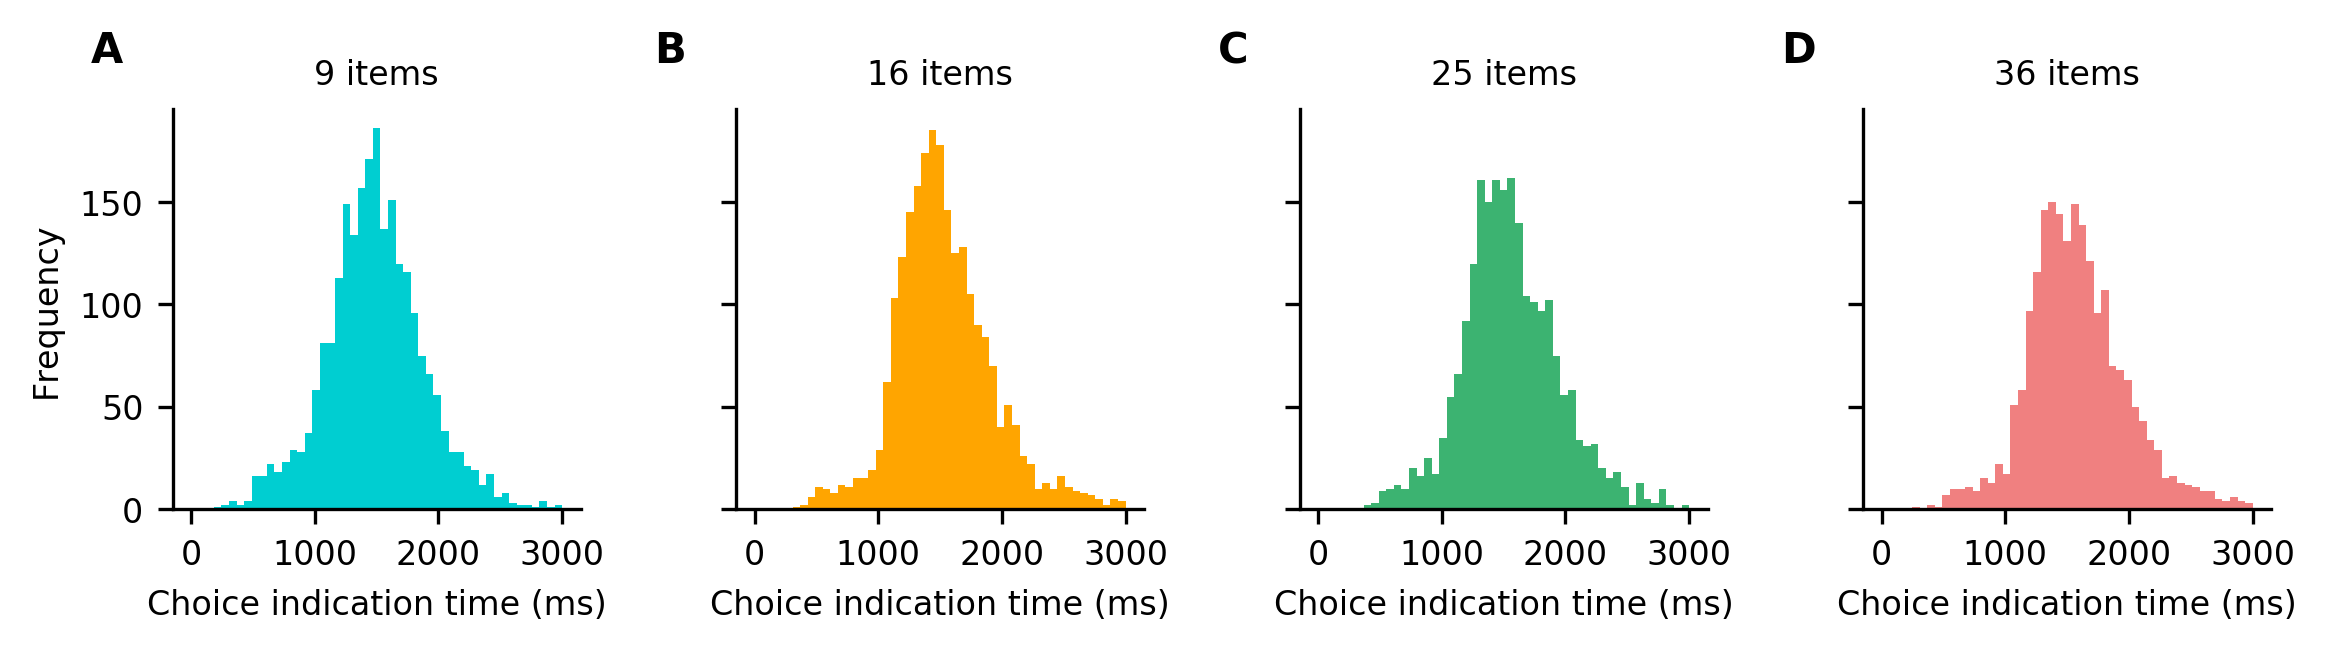

In [3]:
fig, axs = plt.subplots(1, 4, figsize=cm2inch(20,6), dpi=300, sharey=True)
axs[0].set_ylabel('Frequency', fontsize=8)

data = []
for si, (ax, setsize, label) in enumerate(zip(axs, setsizes, list('ABCD'))):
    data_setsize = pd.read_csv('data/summary_files/{}_data.csv'.format(setsize))
    print('Mean: {:4.2f} (SE: {:4.2f})'.format(np.mean(data_setsize['rt_choice_indication'].values),
                                               sem(data_setsize['rt_choice_indication'].values)))
    ax.hist(data_setsize['rt_choice_indication'].values, bins=np.linspace(0,3000,50), color=colors[si])
    ax.set_title('{} items'.format(setsize), fontsize=8)
    ax.set_xlabel('Choice indication time (ms)', fontsize=8)
    ax.set_xticks([0, 1000, 2000, 3000])
    ax.tick_params(axis='both', which='major', labelsize=8)
    despine(ax=ax)
    ax.text(-0.2, 1.2, label, transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top')
    data.append(data_setsize)
data = pd.concat(data)
    
fig.tight_layout()
fig.savefig('figures/Figure-S3_choice-indication-times.pdf', dpi=300)
fig.savefig('figures/Figure-S3_choice-indication-times.png', dpi=300)
fig.savefig('figures/Figure-S3_choice-indication-times.jpg', dpi=300)

## Do choice indication times increase w/ distance of chosen item from the screen center (where the mouse cursor appears)?

In [4]:
screen_center = np.array([1280, 1024])[None,:] / 2 # in px
euclid_dist_from_center = dict()
for setsize in setsizes:
    setsize_positions = pd.read_csv('data/stimulus_positions/{}_stimulus_positions.csv'.format(setsize), header=None).values
    # get item centers
    item_centers = np.concatenate([setsize_positions[:,0][:,None]+(setsize_positions[:,2][:,None]-setsize_positions[:,0][:,None])/2,
                                   setsize_positions[:,1][:,None]+(setsize_positions[:,3][:,None]-setsize_positions[:,1][:,None])/2], axis=1)
    # compute euclidean distance
    item_dist = np.linalg.norm(item_centers-screen_center, axis=1)
    euclid_dist_from_center[setsize] = item_dist
print(euclid_dist_from_center)

{9: array([523.87860579, 322.56      , 517.35588689, 412.8       ,
         0.        , 404.49      , 523.87860579, 322.56      ,
       517.35588689]), 16: array([598.33183355, 401.08995692, 405.26416267, 588.30178713,
       488.33815538, 203.33795637, 211.45262472, 475.99597026,
       488.33815538, 203.33795637, 211.45262472, 475.99597026,
       598.33244881, 401.09087474, 405.26507103, 588.30241288]), 25: array([641.40854067, 468.70574502, 394.4105    , 468.70574502,
       641.39947187, 542.98777623, 321.11662134, 197.46      ,
       321.11662134, 542.9770636 , 505.8115    , 253.23      ,
         0.        , 253.23      , 505.8       , 542.98777623,
       321.11662134, 197.46      , 321.11662134, 542.9770636 ,
       641.40823321, 468.70532427, 394.41      , 468.70532427,
       641.39916441]), 36: array([672.30037311, 521.55032041, 426.65127613, 426.65127613,
       521.55947125, 672.30995666, 585.39252332, 403.37495138,
       269.68115637, 269.68115637, 403.38678303, 585.4

In [5]:
# insert choice distance into data
for setsize in setsizes:
    data.loc[data['setsize']==setsize, 'euclidean_distance_choice'] = euclid_dist_from_center[setsize][data[data['setsize']==setsize]['choice']]

In [6]:
np.random.seed(1234)
mfx_filename = 'choice-indication-time_euclidean-distance_mfx'
if not os.path.isfile(mfx_dir+mfx_filename+'.csv'):
   
    # make model
    n_samples = 2000
    burn = 500
    model = bambi.Model(data=data.copy())
    # add fixed effects
    model.add('rt_choice_indication ~ euclidean_distance_choice + setsize', categorical=['subject'])
    # add random effects
    model.add(random=['1|subject'])
    model.add(random=['0 + euclidean_distance_choice|subject'])
    model.add(random=['0 + setsize|subject'])
    
    # sample posterior
    results = model.fit(samples=n_samples,
                        tune=burn,
                        family='bernoulli',
                        chains=2,
                        backend='pymc',
                        init='ADVI',
                        n_init=50000, 
                        random_seed=12399)
    
    # save results
    pm.trace_to_dataframe(model.backend.trace).to_csv(
        mfx_dir+mfx_filename+'_mtrace.csv', index=False)
    az.plot_trace(results)
    plt.savefig(mfx_dir+mfx_filename+'.png', dpi=220)
    summary = az.summary(results, round_to='none')
    summary.to_csv(mfx_dir+mfx_filename+'.csv')
    
else:
    print(
        'Loading pre-computed posterior trace from: '+mfx_dir)
    summary = pd.read_csv(mfx_dir+mfx_filename+'.csv', index_col='Unnamed: 0')

# extract estimates
_ = get_var(summary, 'Intercept[0]')
_ = get_var(summary, 'euclidean_distance_choice[0]')
_ = get_var(summary, 'setsize[0]')

Loading pre-computed posterior trace from: results/posterior_traces/mixed_effects_models/
Intercept[0]; Mean: 1255.5676027914155, 94% HPD: 1178.1679355725548, 1337.4198922308465
euclidean_distance_choice[0]; Mean: 0.5884481005575753, 94% HPD: 0.5208135203895994, 0.6575501439954948
setsize[0]; Mean: 2.275188104242173, 94% HPD: 1.5689730715032502, 2.9532211595979065
